## Starting the ga-wazpy code

Setting a few packages. The package scikit-image is needed. Install it locally using conda <br>
in the terminal and after restart the kernel. 

Run these 2 lines below in terminal and after that restart kernel:
python -m pip install -U --user pip
python -m pip install -U --user scikit-image

Transformation from DECam g and r to V absolute magnitude: V = g - 0.58*(g-r) - 0.01 (Jester 2005, from SDSS to V)

Control the number of threads in the cell below.

In [1]:
import os
# os.environ['PATH'] += f'{os.pathsep}<CONDA BIN FULL PATH>' # uncomment this line if you need to add conda bin in 'PATH' variable.
!echo $PATH

/home/singulani/bin:/usr/local/bin:/home/singulani/miniconda3/envs/gawa/bin:/home/singulani/miniconda3/condabin:/home/singulani/bin:/usr/local/bin:/home/singulani/.local/bin:/home/singulani/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin:/home/singulani/.fzf/bin


In [2]:
import sys

warn_level = 'ignore'

if not sys.warnoptions:
    import warnings
    warnings.simplefilter(warn_level)
    os.environ["PYTHONWARNINGS"] = warn_level

import numpy as np
import yaml
import os
import astropy.io.fits as fits
import healpy as hp
from astropy.table import Table
import sys
import json

from lib.multithread import split_equal_area_in_threads
from lib.utils import hpx_split_survey
from lib.utils import read_FitsCat, concatenate_fits, create_directory
from lib.utils import create_mosaic_footprint, create_survey_footprint_from_mosaic
from lib.utils import add_key_to_fits
from lib.gawa import compute_cmd_masks, compute_dslices, gawa_concatenate
from lib.gawa import tiles_with_clusters, run_gawa_tile

Below is the main function of the code. If you comment the first line in the cell below,
the function will run sequentially. As it is, the cell runs in parallel.

Survey :  MOCK_DES
workdir :  ./output
.....tile area (deg2) =  13.43
.....effective survey area (deg2) =  91.3744
.....mean, min, max area / thread (deg2) =  9.14 6.11 13.43
Ntiles / Nthreads =  14  /  10
Compute CMD masks
.....Mask distance (kpc) =  81.04
.....Mask distance (kpc) =  89.72
.....Mask distance (kpc) =  99.39
.....Mask distance (kpc) =  110.17
.....Mask distance (kpc) =  122.19


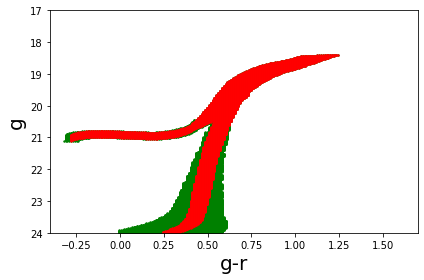

In [3]:
# read config file as online argument 
config = "gawa.cfg"

# read config file
with open(config) as fstream:
    param = yaml.safe_load(fstream)
    fstream.close()
globals().update(param)

# Working & output directories 
workdir = param['out_paths']['workdir']
create_directory(workdir)
create_directory(os.path.join(workdir, 'tiles'))
survey = param['survey']
print ('Survey : ', survey)
print ('workdir : ', workdir)
tiles_filename = os.path.join(workdir, param['admin']['tiling']['tiles_filename'])

# create required data structure if not exist and update config 
if not param['input_data_structure'][survey]['footprint_hpx_mosaic']:
    create_mosaic_footprint(
        param['footprint'][survey], os.path.join(workdir, 'footprint')
    )
    param['footprint'][survey]['mosaic']['dir'] = os.path.join(
        workdir, 'footprint'
    )

ref_bfilter = param['ref_bfilter']
ref_rfilter = param['ref_rfilter']
ref_color = param['ref_color']
isochrone_masks = param['isochrone_masks']

# update parameters with selected filters in config 
param['starcat'][survey]['keys'][
    'key_mag_blue'
] = param['starcat'][survey]['keys']['key_mag'][ref_bfilter]
param['starcat'][survey]['keys'][
    'key_mag_red'
] = param['starcat'][survey]['keys']['key_mag'][ref_rfilter]
isochrone_masks[survey]['magerr_blue_file'] = isochrone_masks[survey]['magerr_file'][ref_bfilter]
isochrone_masks[survey]['magerr_red_file'] = isochrone_masks[survey]['magerr_file'][ref_rfilter]
isochrone_masks[survey]['model_file'] = isochrone_masks[survey]['model_file'][ref_color]
isochrone_masks[survey]['mask_color_min'] = isochrone_masks[survey]['mask_color_min'][ref_color]
isochrone_masks[survey]['mask_color_max'] = isochrone_masks[survey]['mask_color_max'][ref_color]
isochrone_masks[survey]['mask_mag_min'] = isochrone_masks[survey]['mask_mag_min'][ref_bfilter]
isochrone_masks[survey]['mask_mag_max'] = isochrone_masks[survey]['mask_mag_max'][ref_bfilter]

# store config file in workdir
with open(os.path.join(workdir, 'gawa.cfg'), 'w') as outfile:
    json.dump(param, outfile)
    outfile.close()

config = os.path.join(workdir, 'gawa.cfg')    

input_data_structure = param['input_data_structure']
footprint = param['footprint']

# split_area:
if input_data_structure[survey]['footprint_hpx_mosaic']: 
    survey_footprint = os.path.join(workdir, 'survey_footprint.fits')
    if not os.path.isfile(survey_footprint):
        create_survey_footprint_from_mosaic(
            footprint[survey], survey_footprint
        )
else:
    survey_footprint = footprint[survey]['survey_footprint']

if not os.path.isfile(tiles_filename):
    ntiles = hpx_split_survey(
        survey_footprint, footprint[survey], param['admin']['tiling'], tiles_filename
    )
    n_threads, thread_ids = split_equal_area_in_threads(
        param['admin']['nthreads_max'], tiles_filename
    )
    add_key_to_fits(tiles_filename, thread_ids, 'thread_id', 'int')
    all_tiles = read_FitsCat(tiles_filename)
else:
    all_tiles = read_FitsCat(tiles_filename)
    ntiles, n_threads = len(all_tiles), np.amax(all_tiles['thread_id']) 
    thread_ids = all_tiles['thread_id']
print ('Ntiles / Nthreads = ', ntiles, ' / ', n_threads)

gawa_cfg = param['gawa_cfg']

# prepare dslices 
compute_dslices(isochrone_masks[survey], gawa_cfg['dslices'], workdir)

# compute cmd_masks 
print ('Compute CMD masks')

out_paths = param['out_paths']
compute_cmd_masks(isochrone_masks[survey], out_paths, gawa_cfg)

In [4]:
from multiprocessing import Pool

with Pool(3) as p:
    p.map(run_gawa_tile, [(config, ith) for ith in np.unique(thread_ids)])

THREAD  THREAD THREAD 3  
12
..... Tile 
..... Tile ..... Tile    114
6

..........Start gawa tile catalog construction
.............. Detection in slice  0
..........Start gawa tile catalog construction
.............. Detection in slice  0
..........Start gawa tile catalog construction
.............. Detection in slice  0
..............peaks filtering inner tile in / out  504 195
..............peaks filtering coverfrac  in / out  195 195
..............peaks filtering SNR/N      in / out  195 14
         distance / density/arcmin2 =  81.04  /  0.106
.............. Detection in slice  1
..............peaks filtering inner tile in / out  566 209
..............peaks filtering coverfrac  in / out  209 209
..............peaks filtering SNR/N      in / out  209 15
         distance / density/arcmin2 =  81.04  /  0.108
.............. Detection in slice  1
..............peaks filtering inner tile in / out  553 208
..............peaks filtering coverfrac  in / out  208 208
..............peaks f

Wait the results from the previous cells to be finished. Usually it takes about 15 min using a PC (i5 or i7)
with max_threads set to 1.
After the previous cells finished, run the cell below to concatenate the results.

In [5]:
# concatenate
# tiles with clusters 
eff_tiles = tiles_with_clusters(out_paths, all_tiles)
data_clusters = gawa_concatenate(eff_tiles, gawa_cfg, out_paths)
data_clusters.write(
    os.path.join(out_paths['workdir'],'clusters.fits'), overwrite=True
)

print ('all done folks !')
print ('results in ', workdir)

Concatenate clusters
........gawa final filtering
              Nr. of duplicates = 0 / 67
              Final Nr of clusters : 67
all done folks !
results in  ./output


The final product is 'cluster.fits' file. You can compare your final product to the 
file 'sample_data/check_outputs/cluster.fits', which is a product of a previous run.